In [167]:
%matplotlib inline
from neurotools.nlab import *
from neurotools.stats.gmm import *

In [168]:
K  = 17*25
N  = 4000
M  = 5
x  = linspace(-1,1,N)
y  = linspace(-1,1,N)
xy = x[:,None] + 1j*y[None,:]

(1+0j)
(0.809016994375+0.587785252292j)
(0.309016994375+0.951056516295j)
(-0.309016994375+0.951056516295j)
(-0.809016994375+0.587785252292j)


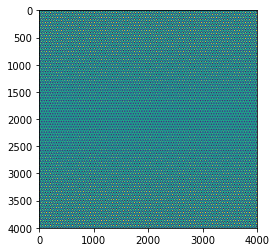

In [169]:
rotation = exp(linspace(0,pi,M+1)[:M]*1j)
xyr = array(xy)*0
for rr in rotation:
    print(rr)
    xyr += cos(real(xy*rr)*K)
qq = xyr
imshow(real(qq))

-10 0
-9 -4
-9 -3
-9 -2
-9 -1
-9 0
-9 1
-9 2
-9 3
-9 4
-8 -6
-8 -5
-8 -4
-8 -3
-8 -2
-8 -1
-8 0
-8 1
-8 2
-8 3
-8 4
-8 5
-8 6
-7 -7
-7 -6
-7 -5
-7 -4
-7 -3
-7 -2
-7 -1
-7 0
-7 1
-7 2
-7 3
-7 4
-7 5
-7 6
-7 7
-6 -8
-6 -7
-6 -6
-6 -5
-6 -4
-6 -3
-6 -2
-6 -1
-6 0
-6 1
-6 2
-6 3
-6 4
-6 5
-6 6
-6 7
-6 8
-5 -8
-5 -7
-5 -6
-5 -5
-5 -4
-5 -3
-5 -2
-5 -1
-5 0
-5 1
-5 2
-5 3
-5 4
-5 5
-5 6
-5 7
-5 8
-4 -9
-4 -8
-4 -7
-4 -6
-4 -5
-4 -4
-4 -3
-4 -2
-4 -1
-4 0
-4 1
-4 2
-4 3
-4 4
-4 5
-4 6
-4 7
-4 8
-4 9
-3 -9
-3 -8
-3 -7
-3 -6
-3 -5
-3 -4
-3 -3
-3 -2
-3 -1
-3 0
-3 1
-3 2
-3 3
-3 4
-3 5
-3 6
-3 7
-3 8
-3 9
-2 -9
-2 -8
-2 -7
-2 -6
-2 -5
-2 -4
-2 -3
-2 -2
-2 -1
-2 0
-2 1
-2 2
-2 3
-2 4
-2 5
-2 6
-2 7
-2 8
-2 9
-1 -9
-1 -8
-1 -7
-1 -6
-1 -5
-1 -4
-1 -3
-1 -2
-1 -1
-1 0
-1 1
-1 2
-1 3
-1 4
-1 5
-1 6
-1 7
-1 8
-1 9
0 -10
0 -9
0 -8
0 -7
0 -6
0 -5
0 -4
0 -3
0 -2
0 -1
0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
1 -9
1 -8
1 -7
1 -6
1 -5
1 -4
1 -3
1 -2
1 -1
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 -9
2 -8

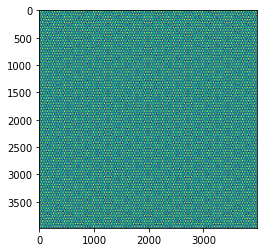

In [170]:

radius = 10
rr = radius**2
d  = radius+1
count = zeros(shape(qq[d:-d,d:-d]))
norm  = 0
for i in arange(-radius,radius+1):
    for j in arange(-radius,radius+1):
        if i*i+j*j>rr: continue
        print(i,j)
        count += qq[d+i:i-d,d+j:j-d]>qq[d:-d,d:-d]
        norm+=1
count /= norm
imshow(count)

In [171]:
from collections import defaultdict

def z2xy(z):
    '''
    Converts an array of complex numbers into two arrays
    representing real and imaginary parts, respectively.
    '''
    return real(z),imag(z)

def uniquerow(x):
    '''
    Removes duplicate rows from a 2D numpy array
    '''
    return array(list(set(map(tuple,x))))

def trianglesToEdges(triangles):
    '''
    Accepts Ntriangles x 3 array of triangle indeces, like the format
    returned by `scipy.spatial.Delaunay(...).simplices`. Returns a
    Nedges x 2 numpy array of unique edges in the triangulation
    '''
    tedges    = triangles[:,[0,1,1,2,2,0]].reshape((size(triangles),2))
    tedges    = uniquerow(sort(tedges,axis=1))
    return tedges

def edgesNearby(iz,microd):
    '''
    Returns a dictionary mapping from 
    indecies into point list iz 
    (2d locations passed as x+iy complex)
    to a list of nearby point indices
    
    Computed by thresholding delaunay triangulation
    '''
    points    = array([real(iz),imag(iz)])
    triangles = scipy.spatial.Delaunay(points.T).simplices
    tedges    = trianglesToEdges(triangles)
    edgelen   = ravel(abs(diff(iz[tedges],axis=1)))
    tedges    = tedges[edgelen<microd,:]
    
    #tedges = concatenate([tedges,tedges[:,[1,0]]])
    #coordsparse = scipy.sparse.coo_matrix((ones(tedges.shape[0]),(tedges[:,0],tedges[:,1])))
    #edgelist = scipy.sparse.csr_matrix(coordsparse)
    
    edgelist  = defaultdict(set)
    for i,z in enumerate(iz):
        edgelist[i] = tuple(ravel(tedges[(tedges==i)[:,[1,0]]]))   
    
    return edgelist

def coalesce(iz,edgelist):
    '''
    Joint connected components as defined in edgelist, and return the centroids
    taken as an average of all point locations in list iz 
    (2d locations passed as x+iy complex)
    '''
    components = {}
    for i in arange(len(iz)):
        components[i]=i
        for e in edgelist[i]:
        #for e in scipy.sparse.find(edgelist[i])[1]:
            if e in components:
                components[i]=components[e]
                break
    componentlist = defaultdict(set)
    for e,cid in components.items():
        componentlist[cid]|={e}
    component_ids = sorted(list(set(components.values())))
    centroids = array([mean(iz[array(list(componentlist[cid]))]) for cid in component_ids])
    return centroids

def plot_edges(iz,edges,**kwargs):
    '''
    Plots a set of edges given by 2d complex numbers and Nedges x 2 array of edge indices
    keword arguments are forwarded to matplotlib.plot
    '''
    edgelist = ravel(np.concatenate([edges[:,:1]*NaN,iz[edges]],axis=1))
    plot(*z2xy(array(edgelist)),**kwargs)
    force_aspect()
    
def plot_triangles(iz,triangles,**kwargs):
    '''
    '''
    edges = trianglesToEdges(triangles)
    edgelist = ravel(np.concatenate([edges[:,:1]*NaN,iz[edges]],axis=1))
    plot(*z2xy(array(edgelist)),**kwargs)
    force_aspect()

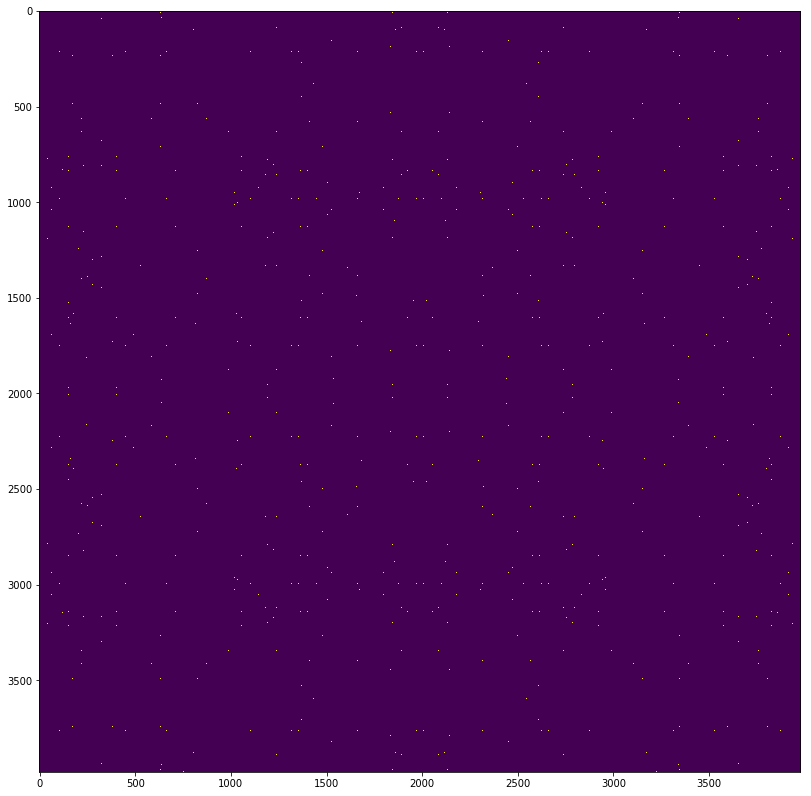

In [172]:
thr = 2e-5
iz = xy[d:-d,d:-d][count<thr]
figure(figsize=(14,14))
imshow(count<thr)
show()

microd = 20.0/K/M
rotation  = exp(linspace(-pi,pi,2*M+1)[:2*M]*1j)
centroids = coalesce(iz,edgesNearby(iz,microd))

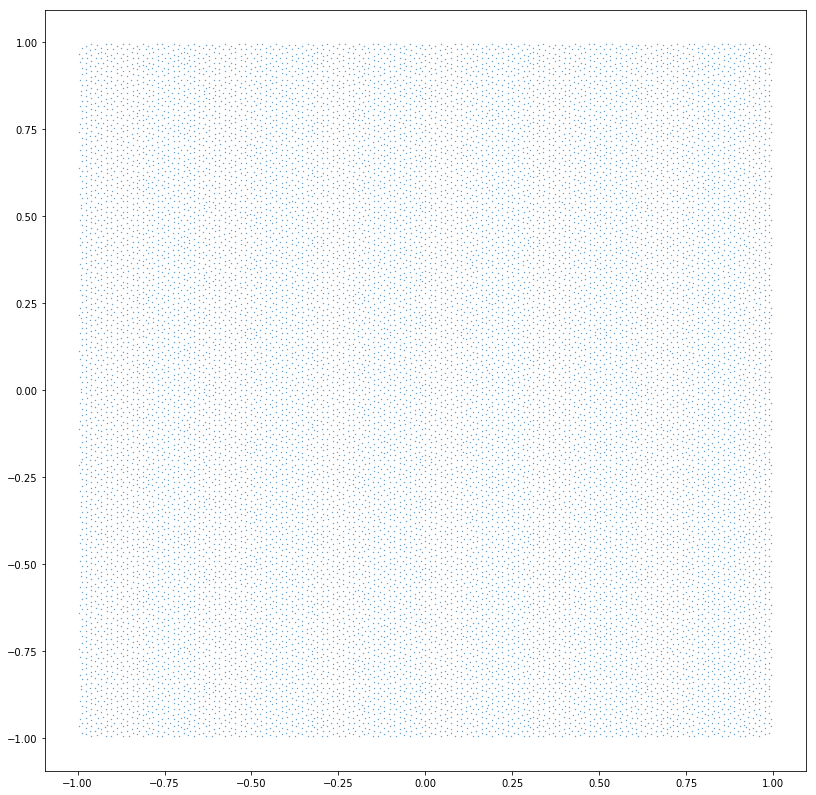

In [173]:
#centroids = np.concatenate([centroids,conj(centroids)])
#centroids = coalesce(centroids,edgesNearby(centroids,microd))
#centroids = np.concatenate([centroids,-1j*conj(1j*centroids)])
#centroids = coalesce(centroids,edgesNearby(centroids,microd))
#centroids = ravel(centroids[:,None]*rotation[None,:])

centroids = array(centroids)
    
figure(figsize=(14,14))
points = array([real(centroids),imag(centroids)])
scatter(*points,s=.1)
force_aspect()

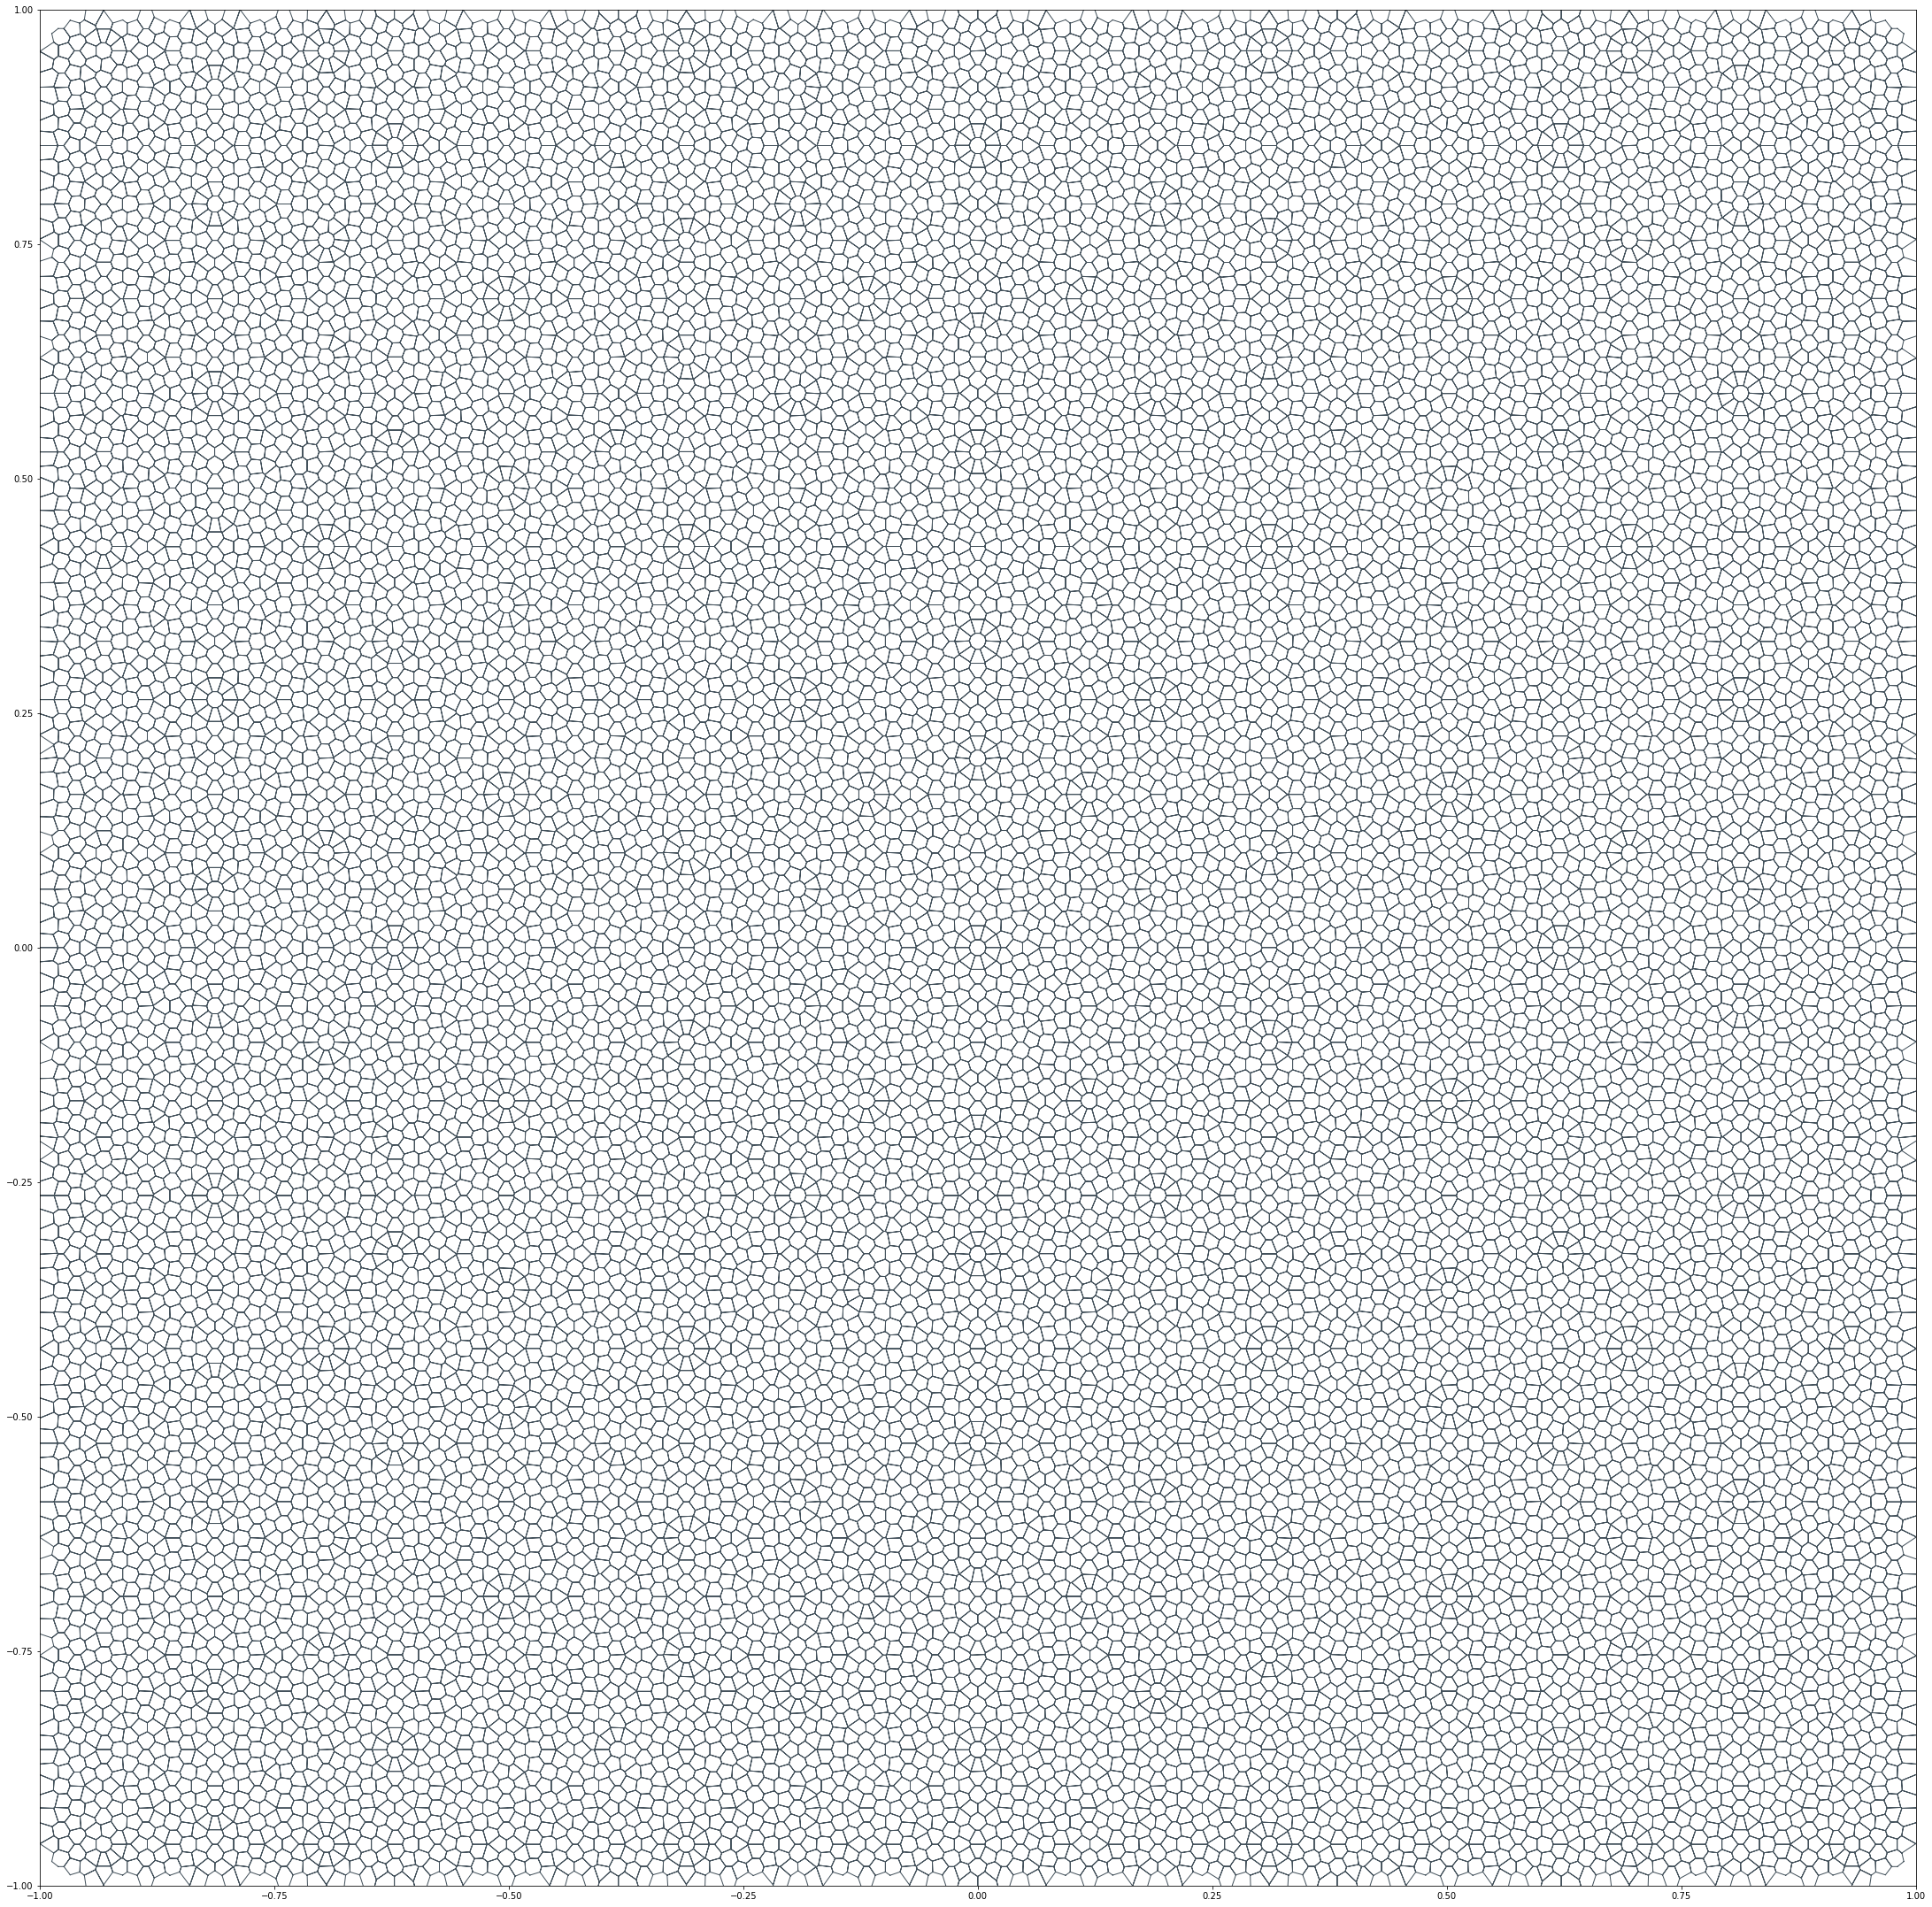

In [174]:
from scipy.spatial import Voronoi, voronoi_plot_2d

points = array([real(centroids),imag(centroids)])
vor = Voronoi(points.T,qhull_options="Qc")
vor.regions
vor.point_region
v = vor.vertices
v = v[:,0]+1j*v[:,1]
ok = array([(all(array(i)>=0)) for i in vor.regions])
r  = array( vor.regions)[ok]
nc = array([mean(v[rr]) for rr in r])

ee = concatenate([array(list(zip(array(e)[arange(-1,len(e))],e))) for e in r])
figure(figsize=(39,39))
plot_edges(v,ee,color=BLACK,lw=1)
degree = array(list(map(len,r)))
#scatter(*z2xy(nc[degree==M+1].T),s=400,color=RUST)
##scatter(*z2xy(nc[degree==M].T),s=400,color=OCHRE)
#scatter(*z2xy(nc[degree==M-1].T),s=400,color=TURQUOISE)
xlim(-1,1)
ylim(-1,1)
force_aspect()

show()

In [175]:
vor.points.shape, len(vor.regions)

((18619, 2), 18619)